# Balancing a Pole on a Cart
## Members

Jden Goh

Alan Lee

Wei Hong

## References


# Importing Dependencies

In [1]:
import numpy as np # used for arrays
import gym # pull the environment
import time # to get the time
import math # needed for calculations
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
# import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import pickle


# Exploring our Cartpole Environment

References:
* https://github.com/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb
* https://www.linkedin.com/pulse/reinforcement-learning-pytorch-mastering-cartpole-v0-akbarnezhad#:~:text=For%20example%2C%20in%20the%20CartPole,as%20observations%20to%20the%20agent.

In [2]:
# Initialise Environment
test_env = gym.make("CartPole-v1")

## Action Space
Action space defines the set of discrete action our agent is allowed to take to interact with the environment.

Our cartpole environment has 2 descrete actions possible, `0` and `1`, as seen by the output `Discrete(2)`:

* `0` - Left
* `1` -> Right

In [3]:
test_env.action_space

Discrete(2)

## Observation Space
Our observation consists of four continuous values:
* **Cart Position**
* **Cart Velocity**
* **Pole Angle**
* **Pole Angular Velocity**

The *min* and *max* for each corresponding values is defined by the output below, in the same order as listed above:

In [4]:
test_env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

# Q-Learning Agent
## Introduction
Q=Learning is an off-model, temporal difference policy, where only need **one-step** trajectory. The Q-Learning agent will store the reards of the **current state** in a `q-table`, and the model will find the best series of action to take based on the **current state** of the agent.

---

## Q-Value
**Q-value** computing (based on lecture notes):
$${\huge Q_{new}(S,A) \leftarrow Q_{old} (S_t , A_t) + \alpha[R + \gamma max_a Q(S',a) - Q_{old}(S_t,A_t)]} $$

where:
* $\alpha \rightarrow$ learning rate
* $\gamma \rightarrow$ discount factor

---

## Implementation:
*note: Our code take reference from this [tutorial](https://www.youtube.com/watch?v=2u1REHeHMrg), we have studeid and understood it, and re-implemented it on our own to ensure that we are able to learn from this tutorial.*

### Observation Space
We have taken the 4 continuous values (in the observation space) and converted into **bins** of discrete ranges using `np.linspace` function.

This is because the CartPole game is **continuous**, while the Q-Learning agent works best in **discrete state space**.

Using the `np.linspace` function, we have changed the 4 continous values into discrete bins

### Q-table
We initialised a `q_table` using `np.zeroes` library. The shape of the library is given by the discrete bins that we have computed earlier, with the inclusion of an additional axis for the action.

For our `trainModel` function, we initialise a new `q-table` and save it as a `.pkl` file using the python `pickle` library.

We can re-use this `q-table` that we have trained later on for our actual runs.


### Parameters:

We have initialised the following parameters for our model (based on our lecture):

* $\alpha $ = 0.1
* $\gamma $ = 0.99

### Epsilon greedy policy
Adopting the **epsilon greedy policy** for this model, we have also intialised the following parameters:
* `epsilon` = 1.0
* `epsilon_decay_rate` = 0.0001

This values help us handle the exploration and exploitation tradeoff. The idea is to decide between:
1. Exploring a new random action, *or*
2. Explointing what the agent knows

In the intial stages of training, the agent relies on trial-and-error to discorver and explore the environment that it has no knowledge on. As the agent learns more and more about the environment, it will then slowly began to exploit its knowledge.

This is implemented using the `epsilon` value and a random value:
* a random number is generated between 0 and 1
* if random number > `epsilon`, we **exploit**
* else, we **explore**

Intially when `epsilon` = 1.0, the agent will focus heavily on **exploring**, but with the implementation of the **epsilon_decay_rate**, the **epsilon** value will gradually decrease and hence, the agent will slowly began to make decisions based on its learned-knowldege.

## References:

https://www.youtube.com/watch?v=2u1REHeHMrg

https://github.com/JackFurby/CartPole-v0

https://towardsdatascience.com/intro-to-reinforcement-learning-temporal-difference-learning-sarsa-vs-q-learning-8b4184bb4978

https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial


In [5]:
class QLearning:
    def __init__(self):
        self.env = gym.make('CartPole-v1')             # our cartpole environment
        self.p_space = np.linspace(-2.4, 2.4, 10)
        self.v_space = np.linspace(-4, 4, 10)
        self.a_space = np.linspace(-.2095, .2095, 10)
        self.av_space = np.linspace(-4, 4, 10)

        self.alpha = 0.1                                # Learning-rate
        self.gamma = 0.99                               # Discount-factor
        self.epsilon = 1                                # Epsilon
        self.epsilon_decay_rate = 0.00001               # Epsilon decay factor
        
        self.is_training = True
        self.end = False
        self.episode_count = 0
        self.reward_episodes = []


    def digitise_state(self, state):
        
        digi_p = np.digitize(state[0],self.p_space)
        digi_v= np.digitize(state[1],self.v_space)
        digi_a=np.digitize(state[2],self.a_space)
        digi_av=np.digitize(state[3],self.av_space)

        return[digi_p, digi_v, digi_a, digi_av]

    #train agent and update q values
    def trainModel(self, desired_mean):
       
        q_table = np.zeros((len(self.p_space)+1, 
                            len(self.v_space)+1, 
                            len(self.a_space)+1, 
                            len(self.av_space)+1, 
                            self.env.action_space.n))

        self.episode_count = 0
        self.reward_episodes = []

        while(True):            
            #initialises the environment
            current_state = self.env.reset()[0]       
            self.end = False
            rewards = 0
            
            #convert the contininous state into discrete bin values for q table to compute 
            
            digi_state = self.digitise_state(current_state)

            
            #close loop when either episode ends or rewards exceeds desired threshold
            while(not self.end and rewards<1000):
                
                #generates random number to determine whether to explore or exploit
                randomNumber=np.random.random()
                if randomNumber < self.epsilon:
                    #selecting a random action
                    action = self.env.action_space.sample()
                else:
                    #selecting action based on q-table
                    action = np.argmax(q_table[digi_state[0], digi_state[1], digi_state[2], digi_state[3], :])

                #executes the action and determines the new state,rewards obtained and whether episode would end
                new_state, reward, self.end, _ ,_ = self.env.step(action)
                
                #convert the next contininous state into discrete bin values for q table to compute 
                new_digi_state = self.digitise_state(new_state)

                                
                #updates q table values                
                q_table[digi_state[0], digi_state[1], digi_state[2], digi_state[3], action] = q_table[digi_state[0], digi_state[1], digi_state[2], digi_state[3], action] + self.alpha * (reward + self.gamma * np.max(q_table[new_digi_state[0], new_digi_state[1], new_digi_state[2], new_digi_state[3],:]) - q_table[digi_state[0], digi_state[1], digi_state[2], digi_state[3],action])


                #prepare next state
                current_state = new_state
                digi_state = new_digis_state

                rewards += reward

            #adds the reward obtained in the current episode to list containing rewards obtained in each episode
            self.reward_episodes.append(rewards)
            
            #calcalates mean rewards obtained over the past 100 epsiodes
            cumulative_rewards = np.mean(self.reward_episodes[len(self.reward_episodes)-100:])
            
            
            #prints out training updates every 100 episodes
            if self.episode_count%100==0:
                print(f'Episode: {self.episode_count}: {rewards}  Epsilon: {self.epsilon:0.2f}  Cumulative_Rewards {cumulative_rewards:0.1f}')
            
            #end training if satisfactory mean rewards values above 500 obtained
            if mean_rewards>desired_mean:
                break

            #decreases exploration rate so agent will lean towards exploitation over time    
            self.epsilon = max(self.epsilon - self.epsilon_decay_rate, 0)
            
            #increment training episode
            self.episode_count+=1

        #close environment
        self.env.close()
        
        #saves q table
        if self.is_training:
            f = open('cartpole.pkl','wb')
            pickle.dump(q_table, f)
            f.close()
    
    #simulate episodes without updating q values
    def simulateEpisodes(self, no_of_episodes):
        
        #create environment
        self.env = gym.make('CartPole-v1', render_mode='human')
        
        #loads q table
        f = open('cartpole.pkl', 'rb')
        q_table = pickle.load(f)
        f.close()

        self.episode_count = 0
        self.reward_episodes = []
 
        for i in range(no_of_episodes):
  
            #initalises the environment
            current_state = self.env.reset()[0]       
            self.end = False
            rewards = 0
            
            #convert the state into discrete bin values
            digi_state = self.digitise_state(current_state)
            
            #close loop when either episode ends
            while(not self.end):
                
                #selecting action based on q-table
                action = np.argmax(q_table[digi_state[0], digi_state[1], digi_state[2], digi_state[3], :])
                
                #convert the next contininous state into discrete bin values for q table to compute 
                new_state, reward, self.end, _ ,_ = self.env.step(action)
                new_digi_state = self.digitise_state(new_state)

                                
                #transitions agent to the next state
                current_state = new_state
                digi_state = new_digi_state
                rewards += reward

            #adds the reward obtained in the current episode to list containing rewards obtained in each episode
            self.reward_episodes.append(rewards)
            
            #calcalates mean rewards obtained over the past 100 epsiodes
            # mean_rewards = np.mean(self.reward_episodes[len(self.reward_episodes)-100:])
            cumulative_rewards = np.mean(self.reward_episodes[:])

            
            #prints out updates every 10 episodes
            if self.episode_count%2==0:
                print(f'Episode: {self.episode_count}: {rewards}  Epsilon: {self.epsilon:0.2f}  Cumulative_Rewards {cumulative_rewards:0.1f}')
            
             #increment training episode
            self.episode_count+=1

        #self.plot()
        #close the environment
        self.env.close()
        
    # returns the action taken for a specific step
    def show_discrete_action(self):
        self.env = gym.make('CartPole-v1')
        
        #loads q table
        f = open('cartpole.pkl', 'rb')
        q_table = pickle.load(f)
        f.close()

        current_state = self.env.reset()[0]
        digi_state = self.digitise_state(current_state)
        
        #selecting action with the largest q value
        action = np.argmax(q_table[digi_state[0], digi_state[1], digi_state[2], digi_state[3], :])
        print("Observation: ", current_state)
        print("Chosen Action: ", action)

    def plot(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.reward_episodes, label='Episode Rewards', color='b')
        plt.title('Cumulative Reward against 100 Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')
        plt.grid(False)
        plt.legend()
        plt.show()
        
        

In [6]:
q_model = QLearning()

# Task 1

In [7]:
q_model.show_discrete_action()

Observation:  [-0.01412232 -0.04381574  0.01499828 -0.03553476]
Chosen Action:  0


# Task 2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0: 866.0  Epsilon: 1.00  Cumulative_Rewards 866.0
Episode: 2: 589.0  Epsilon: 1.00  Cumulative_Rewards 681.0
Episode: 4: 612.0  Epsilon: 1.00  Cumulative_Rewards 644.2
Episode: 6: 611.0  Epsilon: 1.00  Cumulative_Rewards 636.3
Episode: 8: 522.0  Epsilon: 1.00  Cumulative_Rewards 620.3
Episode: 10: 532.0  Epsilon: 1.00  Cumulative_Rewards 612.8
Episode: 12: 567.0  Epsilon: 1.00  Cumulative_Rewards 607.9
Episode: 14: 633.0  Epsilon: 1.00  Cumulative_Rewards 605.3
Episode: 16: 539.0  Epsilon: 1.00  Cumulative_Rewards 597.3
Episode: 18: 565.0  Epsilon: 1.00  Cumulative_Rewards 594.0
Episode: 20: 592.0  Epsilon: 1.00  Cumulative_Rewards 598.2
Episode: 22: 578.0  Epsilon: 1.00  Cumulative_Rewards 598.6
Episode: 24: 1097.0  Epsilon: 1.00  Cumulative_Rewards 633.4
Episode: 26: 585.0  Epsilon: 1.00  Cumulative_Rewards 626.9
Episode: 28: 602.0  Epsilon: 1.00  Cumulative_Rewards 624.9
Episode: 30: 512.0  Epsilon: 1.00  Cumulative_Rewards 620.5
Episode: 32: 568.0  Epsilon: 1.00  Cumulativ

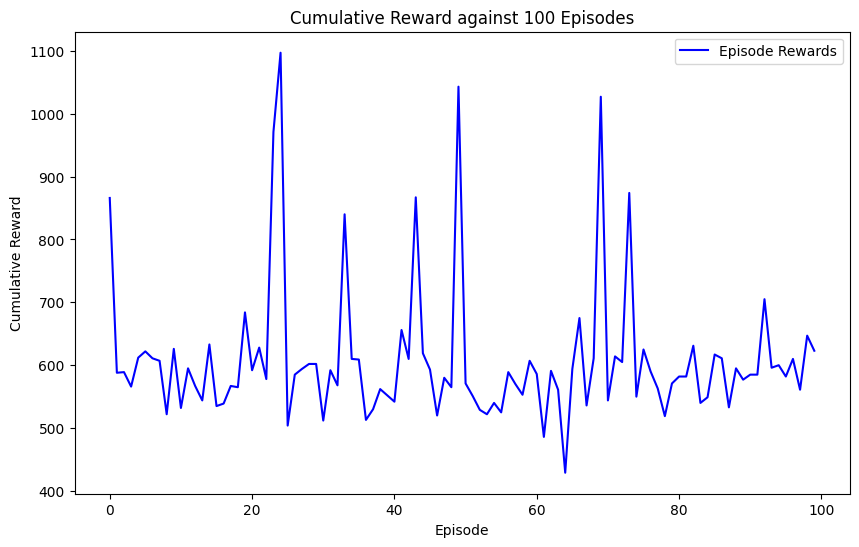

In [8]:
q_model.simulateEpisodes(100)
q_model.plot()

# Task 3